In [1]:
from skimage.transform import resize
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# Catch Environment (from the assignment code)
from Catch import CatchEnv

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\danie\miniconda3\envs\footballtracking\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions
For stuff like plotting the rewards during the training
And for doing the 10 episodes of evaluation seperately from the training

In [2]:
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# plots average rewards over the episodes, in a way that updates the plot during the training loop
def learningPlotter(episodeNumber, avgReward, show_result=False):
    plt.figure(1)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.ylabel('Average reward (over 10 episodes)')
    plt.xlabel('Episode number')
    plt.plot(episodeNumber, avgReward)
    # Take 100 episode averages and plot them too

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())


In [3]:
# does 10 episodes of evaluating the agent; returns the average reward over these 10 episodes
# the agent does not learn, nor store anything in memory, as it is purely exploiting the environment

# the loop is very similar to the training loop code below
def testingTenEpisodes(agent, env):
    total_reward = 0
    for episode in range(10):        

        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device)
        state = state.permute(2, 0, 1).unsqueeze(0) 

        terminal = False
        
        while not terminal:
            action = agent.select_action(state, testing = True)     # testing=True enforces exploitation
            next_state, reward, terminal = env.step(action.item()) 

            if not terminal:
                next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
                next_state = next_state.permute(2, 0, 1).unsqueeze(0)
            
            if terminal:
                next_state = None

            total_reward += reward
            state = next_state


    return total_reward / 10

### Memory buffer, to store the trajectories

In [4]:

from collections import namedtuple, deque

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class MemoryBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity) # iterable deque data structure

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Make a Deep Q-Network

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
# my attempts to tune things
class DQN(nn.Module):
    def __init__(self, number_of_actions):
        super(DQN, self).__init__()
        # conv layers
        self.conv1 = torch.nn.Conv2d(4, 32, 5, stride=3)   # modify input shape to match your input data size
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2)
        # fully connected layers
        self.fc1 = torch.nn.Linear(576, 128)
        self.fc2 = torch.nn.Linear(128, number_of_actions)

        # mat1 and mat2 shapes cannot be multiplied (8x1024 and 16x512)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        #print('doing conv3')
        #x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



class DQN(nn.Module):
    def __init__(self, number_of_actions):
        super(DQN, self).__init__()
        # conv layers
        self.conv1 = torch.nn.Conv2d(4, 32, 5, stride=3)   # modify input shape to match your input data size
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2)
        # fully connected layers
        self.fc1 = torch.nn.Linear(576, 128)
        self.fc2 = torch.nn.Linear(128, number_of_actions)

        # mat1 and mat2 shapes cannot be multiplied (8x1024 and 16x512)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        #print('doing conv3')
        #x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x




# A model that is tiny, but runs much faster (for testing the code without waiting to train a good model)
class speedyDQN(nn.Module):

    def __init__(self, number_of_actions):
        super(speedyDQN, self).__init__()
        # conv layers
        self.conv1 = torch.nn.Conv2d(4, 1, 3, stride=10)   # modify input shape to match your input data size
        # fully connected layers
        self.fc2 = torch.nn.Linear(16, number_of_actions)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2, 2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2, 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [6]:
class Agent(object):
    def __init__(self, num_moves, eps_start, eps_min, eps_decay, memory, batch_size, learning_rate, amsgrad, gamma, target_network_update_rate):
        self.gamma = gamma
        #self.optimizer = optimizer
        self.batch_size = batch_size
        self.memory = memory
        self.num_possible_moves = num_moves
        self.epsilon = eps_start
        self.eps_start = eps_start
        self.eps_min = eps_min
        self.eps_decay = eps_decay

        self.episode = 0
        self.steps = 0
        self.target_network_update_rate = target_network_update_rate

        self.model = DQN(self.num_possible_moves).to(device)
        self.target_network = DQN(self.num_possible_moves).to(device)
        self.target_network.load_state_dict(self.model.state_dict())


        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate, amsgrad=amsgrad)

    
    def select_action(self, state, testing = False): 
        # the 'testing' variable is a way for us to enforce that the agent is exploiting (not exploring) during the 10 episodes of testing
        if np.random.rand() <= self.epsilon and testing == False:
            return torch.tensor([[random.randrange(self.num_possible_moves)]], device=device, dtype=torch.long)

        q_values = self.model(state)
        action = q_values.max(1)[1].view(1, 1)

        return action # returns a tensor of shape [[n]] (where n is the action number)

    def optimize_model(self):
        self.steps += 1
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # use of masking to handle the final states (where there is no next state)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        # concatenate the states, actions and rewards into batches
        batch_of_states = torch.cat(batch.state) 
        batch_of_actions = torch.cat(batch.action)
        batch_of_rewards = torch.cat(batch.reward)

        # get the Q(s_t, a) values for the current state and the chosen action
        state_action_values = self.model(batch_of_states).gather(1, batch_of_actions)

        # Compute state-action values for all next states using the target network:  max(Q(s_{t+1}, a)).
        # 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]  # get the max Q value
        
        # set the temporal difference learning target
        TD_targets = (batch_of_rewards + (self.gamma * next_state_values)  ).unsqueeze(1)


        # Compute the Huber loss
        criterion = nn.SmoothL1Loss()
        TD_loss = criterion(state_action_values, TD_targets)

        # Optimize the model
        self.optimizer.zero_grad()
        TD_loss.backward()
        
        # clip the losses (Huber loss)
        torch.nn.utils.clip_grad_value_(self.model.parameters(), 100)
        self.optimizer.step()


        # update the target network every certain number of steps
        if self.steps % self.target_network_update_rate == 0:
            self.overwrite_target_network()
            

        self.update_eps()

        del non_final_mask, non_final_next_states, batch_of_states, batch_of_actions, batch_of_rewards, state_action_values, next_state_values, TD_targets


    def update_eps(self):
        if self.epsilon > self.eps_min:
            self.epsilon = self.eps_start * np.exp(-self.episode/self.eps_decay)
            # keep the epsilon value from going below the minimum
            if self.epsilon < self.eps_min: 
                self.epsilon = self.eps_min

    # update the target network by overwriting it with the current model
    def overwrite_target_network(self):
        self.target_network.load_state_dict(self.model.state_dict())

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

## Loops

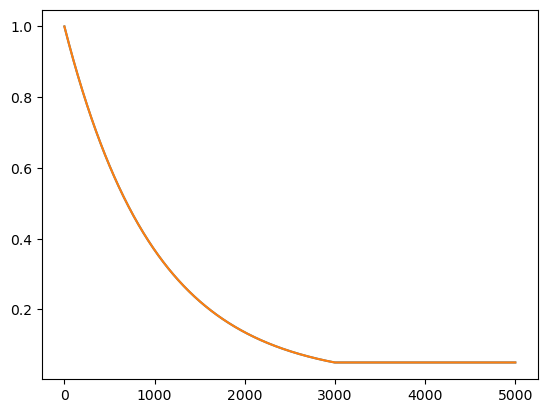

In [11]:
# to see what the decay of epsilon would look like
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 1000 # higher value = slower decay

episodes = np.linspace(0, 5000, 1000) # 5,000 episodes

eps_threshold = EPS_START * np.exp(-episodes / EPS_DECAY)
eps_threshold[eps_threshold < EPS_END] = EPS_END

plt.plot(episodes, eps_threshold)
plt.show()

Complete


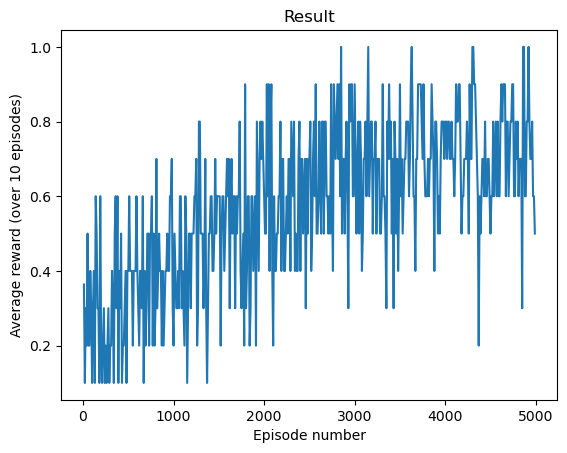

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
if torch.cuda.is_available():
    num_episodes = 5000
else:
    num_episodes = 50

env = CatchEnv()


BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1
EPS_END = 0.05
EPS_DECAY = 2000  
#TAU = 0.005            # <--- we're not using this?
LR = 1e-2
AMSGRAD = True
TARGETNET_UPDATE_RATE = 10
memoryBuffer = MemoryBuffer(5000)
""" this doesn't get used anyway, its defined inside of the agent """
#optimizer = optim.AdamW(policy_network.parameters(), lr=LR, amsgrad=True)
optimizer = None

num_moves = env.get_num_actions()

agent = Agent(num_moves, EPS_START, EPS_END, EPS_DECAY, memoryBuffer, BATCH_SIZE, LR, AMSGRAD, GAMMA, TARGETNET_UPDATE_RATE)



episodeNumber = []
avgReward = []
tempReward = []

testingRewards = []  # this could be turned into the numpy array that we submit for each result file next week

TESTING = False  # if we are doing the evaluation stuff (i.e. for uploading results)
PLOTTING = True # if plotting the rewards over episodes

for episode in range(num_episodes):
    agent.episode += 1

    state = env.reset()
    # get into the dimension [1,4,84,84] by rearranging from [84,84,4] and unsqueezing to add the 1 at the front
    state = torch.tensor(state, dtype=torch.float32, device=device)
    state = state.permute(2, 0, 1).unsqueeze(0) 

    terminal = False
    while not terminal:
        # agent interacts with the environment
        action = agent.select_action(state)    
        next_state, reward, terminal = env.step(action.item())  # .item() just uses the value inside of the tensor
        
        # turn everything into tensors here, before putting in memory
        reward = torch.tensor([reward], device=device)
        if not terminal:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
            next_state = next_state.permute(2, 0, 1).unsqueeze(0)
        
        if terminal:
            next_state = None
            tempReward.append(reward.item())

            # for plotting rewards and/or testing of the agent
            if episode % 10 == 0 and episode > 0:

                episodeNumber.append(episode)

                if TESTING: # 10 seperate episodes of evaluation (no training takes place)
                    score = testingTenEpisodes(agent, env)
                    testingRewards.append(score)
                    if PLOTTING:
                        learningPlotter(episodeNumber, testingRewards)
                        
                elif PLOTTING: # just visualise the rewards over the last 10 training episodes
                    avgReward.append(sum(tempReward)/len(tempReward))
                    tempReward = []
                    learningPlotter(episodeNumber, avgReward)

        # add trajectory to memory buffer
        agent.memory.push(state, action, next_state, reward)

        # move onto the next state
        state = next_state

        # Sample a batch of transitions from the replay buffer and 
        # optimise the learned Q function
        agent.optimize_model()




print('Complete')
if TESTING: learningPlotter(episodeNumber, testingRewards, show_result=True)
else: learningPlotter(episodeNumber, avgReward, show_result=True)
plt.ioff()
plt.show()

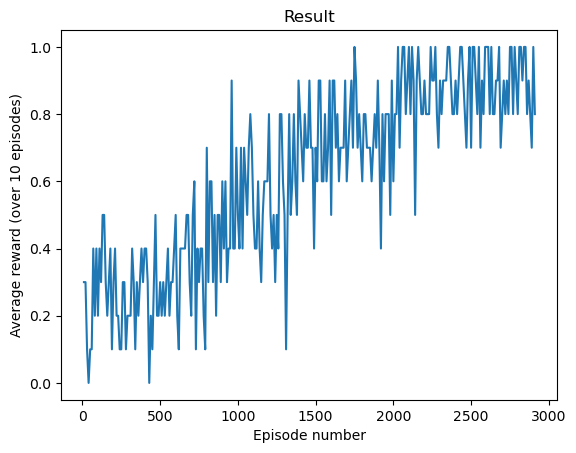

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [55]:
if TESTING: learningPlotter(episodeNumber, testingRewards, show_result=True)
else: learningPlotter(episodeNumber, avgReward, show_result=True)
plt.ioff()
plt.show()

# GRID SEARCH

In [57]:
from sklearn.model_selection import ParameterGrid


BATCH_SIZE = [8, 64, 256]
GAMMA = [0.7, 0.9, 0.99]
EPS_START = [0.8, 0.9, 1]
EPS_END = [0, 0.05, 0.1]
EPS_DECAY = [1000, 1500, 2000, 3000]
#TAU = 0.005            # <--- we're not using this?
LR = [1e-2, 1e-3, 1e-4]
MEMORYBUFFER = [1000, 5000]
AMSGRAD = [True, False]
TARGETNET_UPDATE_RATE = [1, 10, 50]


hyper_grid = {'batch_size' : BATCH_SIZE,
              'gamma' : GAMMA,
              'eps_start' : EPS_START,
              'eps_end' : EPS_END,
              'eps_decay' : EPS_DECAY,
              'learning_rate' : LR,
              'memory_buffer' : MEMORYBUFFER,
              'ams_grad' : AMSGRAD,
              'targetnet_update_rate' : TARGETNET_UPDATE_RATE}

grid = list(ParameterGrid(hyper_grid))
print(len(grid))

for idx, params in enumerate(grid):
    pass

8748


In [ ]:
if torch.cuda.is_available():
    num_episodes = 5000
else:
    num_episodes = 50

env = CatchEnv()

import pandas as pd

RESULTS_DATAFRAME = pd.DataFrame(columns=["DQN_model",'batch_size', 'gamma', 'eps_start', 'eps_end', 'eps_decay', 'learning_rate', 'memory_buffer', 'ams_grad', 'targetnet_update_rate'
                                          "avgRewards", "average_last_100_episodes", "best_average_100_episodes", "time_of_peak", "time_to_convergence"])

memoryBuffer = MemoryBuffer(1000)
""" this doesn't get used anyway, its defined inside of the agent """

num_moves = env.get_num_actions()

agent = Agent(num_moves, EPS_START, EPS_END, EPS_DECAY, memoryBuffer, BATCH_SIZE, LR, AMSGRAD, GAMMA)


episodeNumber = []
RewardsList = []
tempReward = []

convergence = None
best_average = 0
best_episode = None

for episode in range(num_episodes):
    agent.episode += 1

    state = env.reset()
    # get into the dimension [1,4,84,84] by rearranging from [84,84,4] and unsqueezing to add the 1 at the front
    state = torch.tensor(state, dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(0) 


    terminal = False
    while not terminal:
        # agent interacts with the environment
        action = agent.select_action(state)    
        next_state, reward, terminal = env.step(action.item())  # .item() just uses the value inside of the tensor
        
        # turn everything into tensors here, before putting in memory
        reward = torch.tensor([reward], device=device)
        if not terminal:
            next_state = torch.tensor(next_state, dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(0)
        
        if terminal:
            next_state = None
            tempReward.append(reward.item())   
                         

        # add trajectory to memory buffer and move to the next state
        agent.memory.push(state, action, next_state, reward)
        state = next_state

        # optimise the DQN model
        agent.optimize_model()

    # testing of the agent between 10 episode blocks
    if episode % 10 == 0 and episode > 0:
        # store the rewards of the last 10 training episode (NO SEPERATE TESTING HERE, SAVES SOME RUNNING TIME)
        RewardsList.append(sum(tempReward)/len(tempReward))
        tempReward = []

        episodeNumber.append(episode)
        
    # find the best average over 100 episodes
    running_avg = sum(RewardsList[-10:]) / 10   # each element in RewardsList is an average of 10 episodes
    if running_avg > best_average:
        best_average = running_avg
        best_episode = episode
    

    # early stopping
    # if the average of the previous 100 episodes was above 0.9, we've probably hit convergence
    if episode % 10 == 0 and running_avg > 0.9:
        time_to_convergence = episode
        break





"average_last_50_episodes", "best_average_50_episodes", "time_of_peak", "time_to_convergence"

print("Complete")